<a href="https://colab.research.google.com/github/cseveriano/spatio-temporal-forecasting/blob/master/notebooks/thesis_experiments/20200923_eMVFTS_Wind_Energy_SSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Forecasting experiments for GEFCOM2012 Wind Energy Dataset


## Install Libs


In [ ]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS
!pip3 install -U git+https://github.com/cseveriano/spatio-temporal-forecasting
!pip3 install -U git+https://github.com/cseveriano/evolving_clustering
!pip3 install -U git+https://github.com/cseveriano/fts2image
!pip3 install -U hyperopt
!pip3 install -U pyts

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-8f9dftz6
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-8f9dftz6
  Created wheel for pyFTS: filename=pyFTS-1.6-cp36-none-any.whl size=207416 sha256=439f33373b0a35641004f5ae8d8a47705cacd21e114d16d032c51171dffb22b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-y_3ntmsp/wheels/e7/32/a9/230470113df5a73242a5a6d05671cb646db97abf14bbce2644
Successfully built pyFTS
  Cloning https://github.com/cseveriano/spatio-temporal-forecasting to /tmp/pip-req-build-4y_uxvdv
  Running command git clone -q https://github.com/cseveriano/spatio-temporal-forecasting /tmp/pip-req-build-4y_uxvdv
  Created wheel for spatio-temporal-forecasting: filename=spatio_temporal_forecasting-1.0-cp36-none-any.whl size=55633 sha256=74d45dd4463e64adefcf6e9294db1496673208a4eb281771a9191f6cd7f70027
  Stored in directory: /tmp/pip-ephem-wheel-cache-l_fttxag/wheels/d2/1f/6f/439795864246039ef36c6a3c88edf7935c803c2cf97133066a
Succes

In [ ]:
import pandas as pd
import numpy as np
from hyperopt import hp
from spatiotemporal.util import parameter_tuning, sampling
from spatiotemporal.util import experiments as ex
from sklearn.metrics import mean_squared_error
from google.colab import files
import matplotlib.pyplot as plt
import pickle
import math
from pyFTS.benchmarks import Measures
from pyts.decomposition import SingularSpectrumAnalysis
from google.colab import files
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
import datetime

## Aux Functions

In [ ]:
def normalize(df):
    mindf = df.min()
    maxdf = df.max()
    return (df-mindf)/(maxdf-mindf)

def denormalize(norm, _min, _max):
    return [(n * (_max-_min)) + _min for n in norm]


def ssa_decomposition(df, period=144, embedding_dim=15, component_threshold=3):
  main_inds = [i for i in range(component_threshold)]
  res_inds = [i for i in range(component_threshold, embedding_dim)]

  groups = [main_inds, res_inds]

  stations = [c for c in df.columns if c not in ['zen', 'Ics']]
  
  clean_df = pd.DataFrame(columns = stations, index = df.index)
  residual_df = pd.DataFrame(columns = stations, index = df.index)

  for s in stations:
    X = np.array(df[s].values)
    X = X.reshape(1,len(X))
    # Singular Spectrum Analysis
    ssa = SingularSpectrumAnalysis(window_size=embedding_dim, groups=groups)
    X_ssa = ssa.fit_transform(X)

    clean_df[s] = X_ssa[0]
    residual_df[s] = X_ssa[1]
  return clean_df, residual_df


def getRollingWindow(index):
    pivot = index
    train_start = pivot.strftime('%Y-%m-%d')
    pivot = pivot + datetime.timedelta(days=20)
    train_end = pivot.strftime('%Y-%m-%d')

    pivot = pivot + datetime.timedelta(days=1)
    test_start = pivot.strftime('%Y-%m-%d')
    pivot = pivot + datetime.timedelta(days=6)
    test_end = pivot.strftime('%Y-%m-%d')
    
    return train_start, train_end, test_start, test_end

def calculate_rolling_error(cv_name, df, forecasts, order_list):
    cv_results = pd.DataFrame(columns=['Split', 'RMSE', 'SMAPE'])

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    for i in np.arange(len(forecasts)):

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        test = df[test_start : test_end]

        yhat = forecasts[i]

        order = order_list[i]
        rmse = Measures.rmse(test.iloc[order:], yhat[:-1])
        
        smape = Measures.smape(test.iloc[order:], yhat[:-1])
        
        res = {'Split' : index.strftime('%Y-%m-%d') ,'RMSE' : rmse, 'SMAPE' : smape}
        cv_results = cv_results.append(res, ignore_index=True)
        cv_results.to_csv(cv_name+".csv")        

        index = index + datetime.timedelta(days=7)
        
    return cv_results

def reconstruct_ssa_series(clean, residual):
    return [r + c for r, c in zip(residual,clean)]

def get_final_forecast(forecasts_clean, forecasts_residual, order_list_clean, order_list_residual):
    
    forecasts_final = []
    order_list = []
    
    for i in np.arange(len(forecasts_clean)):
        f_clean = denormalize(forecasts_clean[i], min_clean, max_clean)
        f_residual = denormalize(forecasts_residual[i], min_residual, max_residual)

        o_clean = order_list_clean[i]
        o_residual = order_list_residual[i]

        max_order = max(o_clean, o_residual)

        f_final = reconstruct_ssa_series(f_clean[max_order-o_clean:], f_residual[max_order-o_residual:])
        
        forecasts_final.append(f_final)
        order_list.append(max_order)
        
    return forecasts_final, order_list

In [ ]:
from spatiotemporal.test import methods_space_oahu as ms
from spatiotemporal.util import parameter_tuning, sampling
from spatiotemporal.util import experiments as ex
from sklearn.metrics import mean_squared_error
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt import space_eval
import traceback
from . import sampling
import pickle

def calculate_error(loss_function, test_df, forecast, offset):
    error = loss_function(test_df.iloc[(offset):], forecast)
    print("Error : "+str(error))
    return error

def method_optimize(experiment, forecast_method, train_df, test_df, space, loss_function, max_evals):
    def objective(params):
        print(params)
        try:
            _output = list(params['output'])
            forecast = forecast_method(train_df, test_df, params)
            _step = params.get('step', 1)
            offset = params['order'] + _step - 1
            error = calculate_error(loss_function, test_df[_output], forecast, offset)
        except Exception:
            traceback.print_exc()
            error = 1000
        return {'loss': error, 'status': STATUS_OK}

    print("Running experiment: " + experiment)
    trials = Trials()
    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
    print('best parameters: ')
    print(space_eval(space, best))

    pickle.dump(best, open("best_" + experiment + ".pkl", "wb"))
    pickle.dump(trials, open("trials_" + experiment + ".pkl", "wb"))


def run_search(methods, data, train, loss_function, max_evals=100, resample=None):

    if resample:
        data = sampling.resample_data(data, resample)

    train_df, test_df = sampling.train_test_split(data, train)

    for experiment, method, space in methods:
        method_optimize(experiment, method, train_df, test_df, space, loss_function, max_evals)

## Load Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error

In [ ]:
#columns names
wind_farms = ['wp1', 'wp2', 'wp3', 'wp4', 'wp5', 'wp6', 'wp7']

# read raw dataset
import pandas as pd
df = pd.read_csv('https://query.data.world/s/3zx2jusk4z6zvlg2dafqgshqp3oao6',  parse_dates=['date'], index_col=0)
df.index = pd.to_datetime(df.index, format="%Y%m%d%H")

interval = ((df.index >= '2009-07') & (df.index <= '2010-08'))
df = df.loc[interval]

df_ssa_clean, df_ssa_residual = ssa_decomposition(df)


#Normalize Data

# Save Min-Max for Denorm
min_raw = df.min()
min_clean = df_ssa_clean.min()
min_residual = df_ssa_residual.min()

max_raw = df.max()
max_clean = df_ssa_clean.max()
max_residual = df_ssa_residual.max()

# Perform Normalization
norm_df_ssa_clean = normalize(df_ssa_clean)
norm_df_ssa_residual = normalize(df_ssa_residual)

# Tuning split
tuning_ssa_clean = norm_df_ssa_clean["2009-07-01":"2009-07-31"]
tuning_ssa_residual = norm_df_ssa_residual["2009-07-01":"2009-07-31"]

norm_df_ssa_clean = norm_df_ssa_clean["2009-08-01":"2010-08-30"]
norm_df_ssa_residual = norm_df_ssa_residual["2009-08-01":"2010-08-30"]
df = df["2009-08-01":"2010-08-30"]

## Forecasting Methods

### Persistence

In [ ]:
def persistence_forecast(train, test, step):
    predictions = []
    
    for t in np.arange(0,len(test), step):
        yhat = [test.iloc[t]]  * step
        predictions.extend(yhat)
        
    return predictions

def rolling_cv_persistence(df, step):

    forecasts = []
    lags_list = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        test = df[test_start : test_end]
    
        yhat = persistence_forecast(train, test, step)        
        
        lags_list.append(1)
        forecasts.append(yhat)

    return forecasts, lags_list

In [ ]:
forecasts_clean, order_list_clean = rolling_cv_persistence(norm_df_ssa_clean, 1)
forecasts_residual, order_list_residual = rolling_cv_persistence(norm_df_ssa_residual, 1)
forecasts_final, order_list = get_final_forecast(forecasts_clean, forecasts_residual, order_list_clean, order_list_residual)
calculate_rolling_error("rolling_cv_wind_persistence", df, forecasts_final, order_list)

Index:  2009-08-01
Index:  2009-08-08
Index:  2009-08-15
Index:  2009-08-22
Index:  2009-08-29
Index:  2009-09-05
Index:  2009-09-12
Index:  2009-09-19
Index:  2009-09-26
Index:  2009-10-03
Index:  2009-10-10
Index:  2009-10-17
Index:  2009-10-24
Index:  2009-10-31
Index:  2009-11-07
Index:  2009-11-14
Index:  2009-11-21
Index:  2009-11-28
Index:  2009-12-05
Index:  2009-12-12
Index:  2009-12-19
Index:  2009-12-26
Index:  2010-01-02
Index:  2010-01-09
Index:  2010-01-16
Index:  2010-01-23
Index:  2010-01-30
Index:  2010-02-06
Index:  2010-02-13
Index:  2010-02-20
Index:  2010-02-27
Index:  2010-03-06
Index:  2010-03-13
Index:  2010-03-20
Index:  2010-03-27
Index:  2010-04-03
Index:  2010-04-10
Index:  2010-04-17
Index:  2010-04-24
Index:  2010-05-01
Index:  2010-05-08
Index:  2010-05-15
Index:  2010-05-22
Index:  2010-05-29
Index:  2010-06-05
Index:  2010-06-12
Index:  2010-06-19
Index:  2010-06-26
Index:  2010-07-03
Index:  2010-07-10
Index:  2009-08-01
Index:  2009-08-08
Index:  2009

,Split,RMSE,SMAPE
0,2009-08-01,0.059687,35.502280
1,2009-08-08,0.065654,49.897394
2,2009-08-15,0.045409,42.640696
3,2009-08-22,0.057716,34.171760
4,2009-08-29,0.070012,30.266563
5,2009-09-05,0.091666,23.539163
6,2009-09-12,0.100714,27.205763
7,2009-09-19,0.079969,27.289938
8,2009-09-26,0.075298,27.600465
9,2009-10-03,0.081170,26.666622


In [ ]:
files.download('rolling_cv_wind_persistence.csv')

### VAR

In [ ]:
from statsmodels.tsa.api import VAR, DynamicVAR

In [ ]:
def evaluate_VAR_models(test_name, train, validation,target, maxlags_list):
    var_results = pd.DataFrame(columns=['Order','RMSE'])
    best_score, best_cfg, best_model = float("inf"), None, None
    
    for lgs in maxlags_list:
        model = VAR(train)
        results = model.fit(maxlags=lgs, ic='aic')
        
        order = results.k_ar
        forecast = []

        for i in range(len(validation)-order) :
            forecast.extend(results.forecast(validation.values[i:i+order],1))

        forecast_df = pd.DataFrame(columns=validation.columns, data=forecast)
        rmse = Measures.rmse(validation[target].iloc[order:], forecast_df[target].values)

        if rmse < best_score:
            best_score, best_cfg, best_model = rmse, order, results

        res = {'Order' : str(order) ,'RMSE' : rmse}
        print('VAR (%s)  RMSE=%.3f' % (str(order),rmse))
        var_results = var_results.append(res, ignore_index=True)
        var_results.to_csv(test_name+".csv")
        
    print('Best VAR(%s) RMSE=%.3f' % (best_cfg, best_score))
    return best_model

In [ ]:
def var_forecast(train, test, params):
    order = params['order']
    step = params['step']

    model = VAR(train.values)
    results = model.fit(maxlags=order)
    lag_order = results.k_ar
    print("Lag order:" + str(lag_order))
    forecast = []

    for i in np.arange(0,len(test)-lag_order+1,step) :
        forecast.extend(results.forecast(test.values[i:i+lag_order],step))

    forecast_df = pd.DataFrame(columns=test.columns, data=forecast)
    return forecast_df.values, lag_order

In [ ]:
def rolling_cv_var(df, params):
    forecasts = []
    order_list = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        test = df[test_start : test_end]
    
        # Concat train & validation for test
        yhat, lag_order = var_forecast(train, test, params)
        
        forecasts.append(yhat)
        order_list.append(lag_order)

    return forecasts, order_list

In [ ]:
params_clean = {'order': 4, 'step': 1}
params_residual = {'order': 4, 'step': 1}

forecasts_clean, order_list_clean = rolling_cv_var(norm_df_ssa_clean, params_clean)
forecasts_residual, order_list_residual = rolling_cv_var(norm_df_ssa_residual, params_residual)

forecasts_final, order_list = get_final_forecast(forecasts_clean, forecasts_residual, order_list_clean, order_list_residual)
calculate_rolling_error("rolling_cv_wind_var", df, forecasts_final, order_list)

In [ ]:
files.download('rolling_cv_wind_var.csv')

### e-MVFTS

In [ ]:
from spatiotemporal.models.clusteredmvfts.fts import evolvingclusterfts

In [ ]:
def evolvingfts_forecast(train_df, test_df, params, train_model=True):

    _variance_limit = params['variance_limit']
    _defuzzy = params['defuzzy']
    _t_norm = params['t_norm']
    _membership_threshold = params['membership_threshold']
    _order = params['order']
    _step = params['step']


    model = evolvingclusterfts.EvolvingClusterFTS(variance_limit=_variance_limit, defuzzy=_defuzzy, t_norm=_t_norm,
                                                  membership_threshold=_membership_threshold)

    model.fit(train_df.values, order=_order, verbose=False)

    forecast = model.predict(test_df.values, steps_ahead=_step)

    forecast_df = pd.DataFrame(data=forecast, columns=test_df.columns)
    return forecast_df.values

In [ ]:
def rolling_cv_evolving(df, params):
    forecasts = []
    order_list = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    first_time = True

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        test = df[test_start : test_end]
    
        # Concat train & validation for test
        yhat = list(evolvingfts_forecast(train, test, params, train_model=first_time))
        #yhat.append(yhat[-1]) #para manter o formato do vetor de metricas
        forecasts.append(yhat)
        order_list.append(params['order'])

        first_time = False

    return forecasts, order_list

In [ ]:
params_clean = {'variance_limit': 0.001, 'order': 2, 'defuzzy': 'weighted', 't_norm': 'threshold', 'membership_threshold': 0.6, 'step':1}
params_residual = {'variance_limit': 0.001, 'order': 2, 'defuzzy': 'weighted', 't_norm': 'threshold', 'membership_threshold': 0.6, 'step':1}

forecasts_clean, order_list_clean = rolling_cv_evolving(norm_df_ssa_clean, params_clean)
forecasts_residual, order_list_residual = rolling_cv_evolving(norm_df_ssa_residual, params_residual)

forecasts_final, order_list = get_final_forecast(forecasts_clean, forecasts_residual, order_list_clean, order_list_residual)
calculate_rolling_error("rolling_cv_wind_emvfts", df, forecasts_final, order_list)

In [ ]:
files.download('rolling_cv_wind_emvfts.csv')

### MLP

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### MLP Parameter Tuning

In [ ]:
from spatiotemporal.util import parameter_tuning, sampling
from spatiotemporal.util import experiments as ex
from sklearn.metrics import mean_squared_error
from hyperopt import hp
import numpy as np

In [ ]:
mlp_space = {'choice':

   hp.choice('num_layers',
             [
                 {'layers': 'two',
                 },

                 {'layers': 'three',

                   'units3': hp.choice('units3', [8, 16, 64, 128, 256, 512]),
                   'dropout3': hp.choice('dropout3', [0, 0.25, 0.5, 0.75])
                  }

             ]),
   'units1': hp.choice('units1', [8, 16, 64, 128, 256, 512]),
   'units2': hp.choice('units2', [8, 16, 64, 128, 256, 512]),

   'dropout1': hp.choice('dropout1', [0, 0.25, 0.5, 0.75]),
   'dropout2': hp.choice('dropout2', [0, 0.25, 0.5, 0.75]),

   'batch_size': hp.choice('batch_size', [28, 64, 128, 256, 512]),
   'order': hp.choice('order', [1, 2, 3]),
   'input': hp.choice('input', [wind_farms]),
   'output': hp.choice('output', [wind_farms]),
   'epochs': hp.choice('epochs', [100, 200, 300])}


In [ ]:
def mlp_tuning(train_df, test_df, params):
    _input = list(params['input'])
    _nlags = params['order']
    _epochs = params['epochs']
    _batch_size = params['batch_size']
    nfeat = len(train_df.columns)
    nsteps = params.get('step',1)
    nobs = _nlags * nfeat

    output_index = -nfeat*nsteps

    train_reshaped_df = series_to_supervised(train_df[_input], n_in=_nlags, n_out=nsteps)
    train_X, train_Y = train_reshaped_df.iloc[:, :nobs].values, train_reshaped_df.iloc[:, output_index:].values

    test_reshaped_df = series_to_supervised(test_df[_input], n_in=_nlags, n_out=nsteps)
    test_X, test_Y = test_reshaped_df.iloc[:, :nobs].values, test_reshaped_df.iloc[:, output_index:].values

    # design network
    model = Sequential()
    model.add(Dense(params['units1'], input_dim=train_X.shape[1], activation='relu'))
    model.add(Dropout(params['dropout1']))
    model.add(BatchNormalization())

    model.add(Dense(params['units2'], activation='relu'))
    model.add(Dropout(params['dropout2']))
    model.add(BatchNormalization())

    if params['choice']['layers'] == 'three':
        model.add(Dense(params['choice']['units3'], activation='relu'))
        model.add(Dropout(params['choice']['dropout3']))
        model.add(BatchNormalization())

    model.add(Dense(train_Y.shape[1], activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')

    # includes the call back object
    model.fit(train_X, train_Y, epochs=_epochs, batch_size=_batch_size, verbose=False, shuffle=False)

    # predict the test set
    forecast = model.predict(test_X, verbose=False)

    return forecast


In [ ]:
methods = []
methods.append(("EXP_wind_MLP", mlp_tuning, mlp_space))
train_split = 0.6
run_search(methods, tuning_ssa_residual, train_split, Measures.rmse, max_evals=30, resample=None)

#### MLP Forecasting

In [ ]:
def mlp_multi_forecast(train_df, test_df, params):

    
    nfeat = len(train_df.columns)
    nlags = params['order']
    nsteps = params.get('step',1)
    nobs = nlags * nfeat

    output_index = -nfeat*nsteps

    train_reshaped_df = series_to_supervised(train_df, n_in=nlags, n_out=nsteps)
    train_X, train_Y = train_reshaped_df.iloc[:, :nobs].values, train_reshaped_df.iloc[:, output_index:].values

    test_reshaped_df = series_to_supervised(test_df, n_in=nlags, n_out=nsteps)
    test_X, test_Y = test_reshaped_df.iloc[:, :nobs].values, test_reshaped_df.iloc[:, output_index:].values
    
    # design network
    model = designMLPNetwork(train_X.shape[1], train_Y.shape[1], params)
    
    # fit network
    model.fit(train_X, train_Y, epochs=500, batch_size=1000, verbose=False, shuffle=False)
    
    forecast = model.predict(test_X)
    
#    fcst = [f[0] for f in forecast]
    fcst = forecast
    return fcst

In [ ]:
def designMLPNetwork(input_shape, output_shape, params):
    model = Sequential()
    model.add(Dense(params['units1'], input_dim=input_shape, activation='relu'))
    model.add(Dropout(params['dropout1']))
    model.add(BatchNormalization())

    model.add(Dense(params['units2'], activation='relu'))
    model.add(Dropout(params['dropout2']))
    model.add(BatchNormalization())

    if params['choice']['layers'] == 'three':
        model.add(Dense(params['choice']['units3'], activation='relu'))
        model.add(Dropout(params['choice']['dropout3']))
        model.add(BatchNormalization())

    model.add(Dense(output_shape, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')

    return model

In [ ]:
def rolling_cv_mlp(df, params):
    
    forecasts = []
    order_list = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        test = df[test_start : test_end]

        # Perform forecast
        yhat = list(mlp_multi_forecast(train, test, params))
        
        yhat.append(yhat[-1]) #para manter o formato do vetor de metricas
        
        forecasts.append(yhat)
        order_list.append(params['order'])

    return forecasts, order_list

In [ ]:
# Enter best params
params_clean = {'batch_size': 512, 'choice': {'dropout3': 0.25, 'layers': 'three', 'units3': 128}, 'dropout1': 0.25, 'dropout2': 0.25, 'epochs': 200, 'input': ('DH3', 'DH4', 'DH5', 'DH10', 'DH9', 'DH2', 'AP1', 'DH6', 'DH7', 'AP2'), 'order': 2, 'output': ('DH3', 'DH4', 'DH5', 'DH10', 'DH9', 'DH2', 'AP1', 'DH6', 'DH7', 'AP2'), 'units1': 256, 'units2': 512}

params_residual = {'batch_size': 128, 'choice': {'dropout3': 0.25, 'layers': 'three', 'units3': 256}, 'dropout1': 0.25, 'dropout2': 0.25, 'epochs': 200, 'input': ('DH3', 'DH4', 'DH5', 'DH10', 'DH9', 'DH2', 'AP1', 'DH6', 'DH7', 'AP2'), 'order': 3, 'output': ('DH3', 'DH4', 'DH5', 'DH10', 'DH9', 'DH2', 'AP1', 'DH6', 'DH7', 'AP2'), 'units1': 512, 'units2': 512}

forecasts_clean, order_list_clean = rolling_cv_mlp(norm_df_ssa_clean, params_clean)
forecasts_residual, order_list_residual = rolling_cv_mlp(norm_df_ssa_residual, params_residual)

forecasts_final, order_list = get_final_forecast(forecasts_clean, forecasts_residual, order_list_clean, order_list_residual)
calculate_rolling_error("rolling_cv_wind_mlp_multi", df, forecasts_final, order_list)

In [ ]:
files.download('rolling_cv_wind_mlp_multi.csv')

### Granular FTS

In [ ]:
from pyFTS.models.multivariate import granular
from pyFTS.partitioners import Grid, Entropy
from pyFTS.models.multivariate import variable
from pyFTS.common import Membership
from pyFTS.partitioners import Grid, Entropy

#### Granular Parameter Tuning

In [ ]:
granular_space = {
    'npartitions': hp.choice('npartitions', [100, 150, 200]),
    'order': hp.choice('order', [1, 2]),
    'knn': hp.choice('knn', [1, 2, 3, 4, 5]),
    'alpha_cut': hp.choice('alpha_cut', [0, 0.1, 0.2, 0.3]),
   'input': hp.choice('input', [['wp1', 'wp2', 'wp3']]),
   'output': hp.choice('output', [['wp1', 'wp2', 'wp3']])}

In [ ]:
def granular_tuning(train_df, test_df, params):
    _input = list(params['input'])
    _output = list(params['output'])
    _npartitions = params['npartitions']
    _order = params['order']
    _knn = params['knn']
    _alpha_cut = params['alpha_cut']
    _step = params.get('step',1)

    ## create explanatory variables
    exp_variables = []
    for vc in _input:
        exp_variables.append(variable.Variable(vc, data_label=vc, alias=vc,
                                               npart=_npartitions, func=Membership.trimf,
                                               data=train_df, alpha_cut=_alpha_cut))
    model = granular.GranularWMVFTS(explanatory_variables=exp_variables, target_variable=exp_variables[0], order=_order,
                                    knn=_knn)
    model.fit(train_df[_input], num_batches=1)

    if _step > 1:
        forecast = pd.DataFrame(columns=test_df.columns)
        length = len(test_df.index)

        for k in range(0,(length -(_order + _step - 1))):
            fcst = model.predict(test_df[_input], type='multivariate', start_at=k, steps_ahead=_step)
            forecast = forecast.append(fcst.tail(1))
    else:
        forecast = model.predict(test_df[_input], type='multivariate')

    return forecast[_output].values


In [ ]:
methods = []
methods.append(("EXP_WIND_GRANULAR", granular_tuning, granular_space))

In [ ]:
train_split = 0.6
run_search(methods, norm_df_ssa_clean, train_split, Measures.rmse, max_evals=10, resample=None)

#### Granular Forecasting

In [ ]:
def granular_forecast(train_df, test_df, params):

    _input = list(params['input'])
    _output = list(params['output'])
    _npartitions = params['npartitions']
    _knn = params['knn']
    _alpha_cut = params['alpha_cut']
    _order = params['order']
    _step = params.get('step',1)

    ## create explanatory variables
    exp_variables = []
    for vc in _input:
        exp_variables.append(variable.Variable(vc, data_label=vc, alias=vc,
                                               npart=_npartitions, func=Membership.trimf,
                                               data=train_df, alpha_cut=_alpha_cut))
    model = granular.GranularWMVFTS(explanatory_variables=exp_variables, target_variable=exp_variables[0], order=_order,
                                    knn=_knn)
    model.fit(train_df[_input], num_batches=1)

    if _step > 1:
        forecast = pd.DataFrame(columns=test_df.columns)
        length = len(test_df.index)

        for k in range(0,(length -(_order + _step - 1))):
            fcst = model.predict(test_df[_input], type='multivariate', start_at=k, steps_ahead=_step)
            forecast = forecast.append(fcst.tail(1))
    else:
        forecast = model.predict(test_df[_input], type='multivariate')

    return forecast[_output].values


In [ ]:
def rolling_cv_granular(df, params):
    
    forecasts = []
    order_list = []

    limit = df.index[-1].strftime('%Y-%m-%d')

    test_end = ""
    index = df.index[0]

    while test_end < limit :
        print("Index: ", index.strftime('%Y-%m-%d'))  

        train_start, train_end, test_start, test_end = getRollingWindow(index)
        index = index + datetime.timedelta(days=7)
        
        train = df[train_start : train_end]
        test = df[test_start : test_end]


        # Perform forecast
        yhat = list(granular_forecast(train, test, params))
        
        yhat.append(yhat[-1]) #para manter o formato do vetor de metricas
        
        forecasts.append(yhat)
        order_list.append(params['order'])

    return forecasts, order_list

In [ ]:
def granular_get_final_forecast(forecasts_clean, forecasts_residual, order_list_clean, order_list_residual, input):
    
    forecasts_final = []
    order_list = []
    l_min_clean = df_ssa_clean[input].min()
    l_min_residual = df_ssa_residual[input].min()

    l_max_clean = df_ssa_clean[input].max()
    l_max_residual = df_ssa_residual[input].max()


    for i in np.arange(len(forecasts_clean)):
        f_clean = denormalize(forecasts_clean[i], l_min_clean, l_max_clean)
        f_residual = denormalize(forecasts_residual[i], l_min_residual, l_max_residual)

        o_clean = order_list_clean[i]
        o_residual = order_list_residual[i]

        max_order = max(o_clean, o_residual)

        f_final = reconstruct_ssa_series(f_clean[max_order-o_clean:], f_residual[max_order-o_residual:])
        
        forecasts_final.append(f_final)
        order_list.append(max_order)
        
    return forecasts_final, order_list

In [ ]:
# Enter best params
params_clean = {'alpha_cut': 0.2, 'input': ('wp1', 'wp2', 'wp3'), 'knn': 5, 'npartitions': 150, 'order': 2, 'output': ('wp1', 'wp2', 'wp3')}

params_residual = {'alpha_cut': 0.3, 'input': ('wp1', 'wp2', 'wp3'), 'knn': 5, 'npartitions': 100, 'order': 1, 'output': ('wp1', 'wp2', 'wp3')}

forecasts_clean, order_list_clean = rolling_cv_granular(norm_df_ssa_clean, params_clean)
forecasts_residual, order_list_residual = rolling_cv_granular(norm_df_ssa_residual, params_residual)

forecasts_final, order_list = granular_get_final_forecast(forecasts_clean, forecasts_residual, order_list_clean, order_list_residual, list(params_clean['input']))
calculate_rolling_error("rolling_cv_wind_granular", df[list(params_clean['input'])], forecasts_final, order_list)

In [ ]:
files.download('rolling_cv_wind_granular.csv')

## Result Analysis

In [ ]:
import pandas as pd
from google.colab import files

In [ ]:
files.upload()

Saving rolling_cv_wind_emvfts.csv to rolling_cv_wind_emvfts.csv
Saving rolling_cv_wind_granular.csv to rolling_cv_wind_granular.csv
Saving rolling_cv_wind_mlp_multi.csv to rolling_cv_wind_mlp_multi.csv
Saving rolling_cv_wind_var.csv to rolling_cv_wind_var.csv


{'rolling_cv_wind_emvfts.csv': b',Split,RMSE,SMAPE\n0,2009-08-01,0.060397095668822176,35.50691384763904\n1,2009-08-08,0.09090499661661794,62.175170171902586\n2,2009-08-15,0.09554319895850022,52.50421828310069\n3,2009-08-22,0.05171509441636752,32.306863778302045\n4,2009-08-29,0.06480109807478217,28.46925436222178\n5,2009-09-05,0.08133139627788369,22.304515756812773\n6,2009-09-12,0.08726448756735339,26.22862930937531\n7,2009-09-19,0.07183436817969328,24.64110220738373\n8,2009-09-26,0.07501241131816644,27.029586159899647\n9,2009-10-03,0.07076212019548815,25.13867945728339\n10,2009-10-10,0.08198978193531437,28.939270979023917\n11,2009-10-17,0.08772595391841373,24.45322167758411\n12,2009-10-24,0.08346332577654837,16.082238012765835\n13,2009-10-31,0.08794084241973336,34.84357688810383\n14,2009-11-07,0.09076896027036507,22.128024679663532\n15,2009-11-14,0.08355835076559132,18.436703837298204\n16,2009-11-21,0.09102646621724252,21.816012364271007\n17,2009-11-28,0.0623746441258711,33.06501617747

In [ ]:
def createBoxplot(filename, data, xticklabels, ylabel):
    # Create a figure instance
    fig = plt.figure(1, figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the boxplot
    bp = ax.boxplot(data, patch_artist=True)
    
    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='#7570b3', linewidth=2)
        # change fill color
        box.set( facecolor = '#AACCFF' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#FFE680', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)
    
    ## Custom x-axis labels
    ax.set_xticklabels(xticklabels)
    ax.set_ylabel(ylabel)
    plt.show()
    fig.savefig(filename, bbox_inches='tight')

In [ ]:
var_results = pd.read_csv("rolling_cv_wind_var.csv")
evolving_results = pd.read_csv("rolling_cv_wind_emvfts.csv")
mlp_results = pd.read_csv("rolling_cv_wind_mlp_multi.csv")
granular_results = pd.read_csv("rolling_cv_wind_granular.csv")

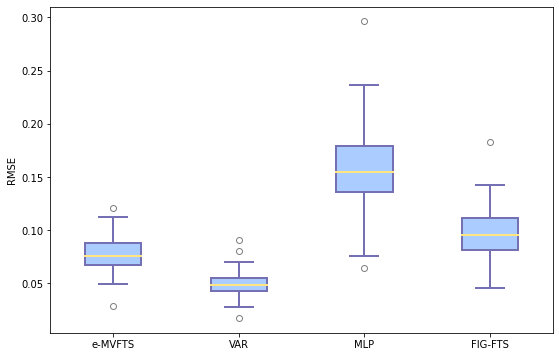

In [ ]:
metric = 'RMSE'
results_data = [evolving_results[metric],var_results[metric], mlp_results[metric], granular_results[metric]]
xticks = ['e-MVFTS','VAR','MLP','FIG-FTS']

ylab = 'RMSE'
createBoxplot("e-mvfts_boxplot_rmse_wind", results_data, xticks, ylab)

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
metric = 'RMSE'
rmse_df = pd.DataFrame(columns=['e-MVFTS','VAR','MLP','FIG-FTS'])

rmse_df["e-MVFTS"] = evolving_results[metric]
rmse_df["VAR"] = var_results[metric]
rmse_df["MLP"] = mlp_results[metric]
rmse_df["FIG-FTS"] = granular_results[metric]

In [ ]:
rmse_df.std()

e-MVFTS   0.02
VAR       0.01
MLP       0.04
FIG-FTS   0.03
dtype: float64

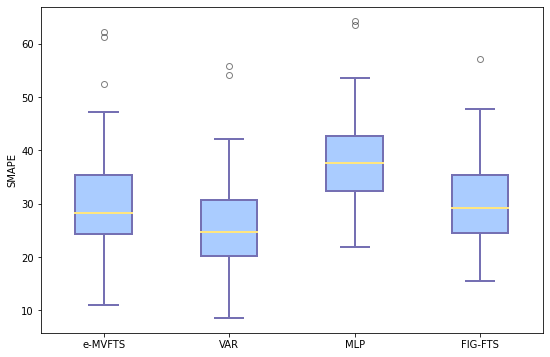

In [ ]:
metric = 'SMAPE'
results_data = [evolving_results[metric],var_results[metric], mlp_results[metric], granular_results[metric]]
xticks = ['e-MVFTS','VAR','MLP','FIG-FTS']

ylab = 'SMAPE'
createBoxplot("e-mvfts_boxplot_smape_wind", results_data, xticks, ylab)

In [ ]:
metric = 'SMAPE'
smape_df = pd.DataFrame(columns=['e-MVFTS','VAR','MLP','FIG-FTS'])

smape_df["e-MVFTS"] = evolving_results[metric]
smape_df["VAR"] = var_results[metric]
smape_df["MLP"] = mlp_results[metric]
smape_df["FIG-FTS"] = granular_results[metric]

In [ ]:
smape_df.std()

e-MVFTS   10.75
VAR        9.84
MLP        9.42
FIG-FTS    8.51
dtype: float64

In [ ]:
metric = "RMSE"

data = pd.DataFrame(columns=["Persistence", "VAR", "Evolving", "MLP", "Granular"])

data["Persistence"] = persistence_results[metric]
data["VAR"] = var_results[metric]
data["Evolving"] = evolving_results[metric]
data["MLP"] = mlp_results[metric]
data["Granular"] = granular_results[metric]

ax = data.plot(figsize=(18,6))
ax.set(xlabel='Window', ylabel=metric)
fig = ax.get_figure()
#fig.savefig(path_images + exp_id + "_prequential.png")
    
x = np.arange(len(data.columns.values))
names = data.columns.values
values = data.mean().values
plt.figure(figsize=(5,6))
plt.bar(x, values, align='center', alpha=0.5, width=0.9)
plt.xticks(x, names)
#plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel(metric)
#plt.savefig(path_images + exp_id + "_bars.png")

In [ ]:
metric = "SMAPE"

data = pd.DataFrame(columns=["Persistence", "VAR", "Evolving", "MLP", "Granular"])

data["Persistence"] = persistence_results[metric]
data["VAR"] = var_results[metric]
data["Evolving"] = evolving_results[metric]
data["MLP"] = mlp_results[metric]
data["Granular"] = granular_results[metric]

ax = data.plot(figsize=(18,6))
ax.set(xlabel='Window', ylabel=metric)
fig = ax.get_figure()
#fig.savefig(path_images + exp_id + "_prequential.png")
    
x = np.arange(len(data.columns.values))
names = data.columns.values
values = data.mean().values
plt.figure(figsize=(5,6))
plt.bar(x, values, align='center', alpha=0.5, width=0.9)
plt.xticks(x, names)
#plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel(metric)
#plt.savefig(path_images + exp_id + "_bars.png")